In [102]:
import numpy as np
import os
import jieba
from collections import Counter  #计数器
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.data.utils import get_tokenizer  #分词器
from torch.utils.data import DataLoader

from train import train_epoch, evaluate
from model import myTransformer
import torch.optim as optim

from build import build_pipe, build_vocab, compute_args

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

UNK_IDX = 0  #未知
PAD_IDX = 1  #
BATCH_SIZE = 64
EPOCHS = 60
DROPOUT = 0.2
ENC_HIDDEN_SIZE = DEC_HIDDEN_SIZE = 100
EMBED_SIZE = 64
N_HEADS = 8#EMBED_SIZE整除N_HEADS
N_LAYERS = 6 #encoder 和 decoder 层数
D_FF = 2048 # 前馈全连接神经网络的维度
DEBUG = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.getcwd().endswith("sy"):
    os.chdir("..")

DATA = "attn_data"



In [55]:
if DATA == "attn_data":

    if DEBUG:

        train_file = 'attn_data/train_mini.txt'
        dev_file = 'attn_data/dev_mini.txt'
        test_file = 'attn_data/test_mini.txt'
        save_file = 'model.pt'
    else:

        train_file = '/root/autodl-tmp/attention/attn_data/train.txt'
        dev_file = '/root/autodl-tmp/attention/attn_data/dev.txt'
        test_file = '/root/autodl-tmp/attention/attn_data/test.txt'
        save_file = 'large_model.pt'

    #分词器
    tokenizer_en = get_tokenizer('basic_english')  #按空格进行分割
    tokenizer_cn = get_tokenizer(jieba.lcut)  #进行结巴分词


    #加载文件
    def load_data(path):
        en = []
        cn = []
        with open(path, 'r', encoding = 'utf-8') as f:
            for line in f:
                line = line.strip().split('\t')
                en.append(["BOS"] + tokenizer_en(line[0].lower()) + ["EOS"])  #小写
                cn.append(["BOS"] + tokenizer_cn(line[1]) + ["EOS"])
        return en, cn


    train_en, train_zh = load_data(train_file)
    dev_en, dev_zh = load_data(dev_file)
    test_en, test_zh = load_data(test_file)

    #构建词汇表
    def build_dict(sentences, max_words = 50000):
        vocab = Counter(np.concatenate(sentences)).most_common(max_words)  #最大单词数是50000
        word_to_id = {w[0]: index + 2 for index, w in enumerate(vocab)}
        word_to_id['UNK'] = UNK_IDX  #0
        word_to_id['PAD'] = PAD_IDX  #1
        id_to_word = {v: k for k, v in word_to_id.items()}
        return word_to_id, id_to_word


    en_wtoi, en_itow = build_dict(train_en)
    zh_wtoi, zh_itow = build_dict(train_zh)


    # 利用词典对原始句子编码 单词->数字
    def encode(en_sentences, ch_sentences, en_wtoi, zh_wtoi, sort_by_len = True):
        out_en_sentences = [[en_wtoi.get(w, UNK_IDX) for w in sent] for sent in en_sentences]
        out_ch_sentences = [[zh_wtoi.get(w, UNK_IDX) for w in sent] for sent in ch_sentences]

        #返回w对应的值，否则返回UNK_IDX
        def len_argsort(seq):  #按照长度进行排序
            return sorted(range(len(seq)), key = lambda x: len(seq[x]))

        # 把中文和英文按照同样的顺序排序
        if sort_by_len:
            sorted_index = len_argsort(out_en_sentences)
            out_en_sentences = [out_en_sentences[i] for i in sorted_index]
            out_ch_sentences = [out_ch_sentences[i] for i in sorted_index]

        return out_en_sentences, out_ch_sentences


    train_en_encode, train_zh_encode = encode(train_en, train_zh, en_wtoi, zh_wtoi)
    dev_en_encode, dev_zh_encode = encode(dev_en, dev_zh, en_wtoi, zh_wtoi)
    test_en_encode, test_zh_encode = encode(test_en, test_zh, en_wtoi, zh_wtoi)


    #返回每个batch的id
    def get_minibatches(n, minibatch_size, shuffle = True):
        idx_list = np.arange(0, n, minibatch_size)
        if shuffle:
            np.random.shuffle(idx_list)
        minibatches = []
        for idx in idx_list:
            minibatches.append(np.arange(idx, min(idx + minibatch_size, n)))
        return minibatches

    #将句子对划分到batch
    def get_batches(en_encode, ch_encode):
        batch_indexs = get_minibatches(len(en_encode), BATCH_SIZE)

        batches = []
        for batch_index in batch_indexs:
            batch_en = [torch.tensor(en_encode[index]).long() for index in batch_index]  #每一个idx对应的句子，转为tensor格式
            batch_zh = [torch.tensor(ch_encode[index]).long() for index in batch_index]
            length_en = torch.tensor([len(en) for en in batch_en]).long()  #每一个句子的长度
            length_zh = torch.tensor([len(zh) for zh in batch_zh]).long()

            batch_en = pad_sequence(batch_en, padding_value = PAD_IDX, batch_first = True)  #讲一个batch中的句子padding为相同长度
            batch_zh = pad_sequence(batch_zh, padding_value = PAD_IDX, batch_first = True)

            batches.append((batch_en, batch_zh, length_en, length_zh))
        return batches


    train_data = get_batches(train_en_encode, train_zh_encode)
    dev_data = get_batches(dev_en_encode, dev_zh_encode)

elif DATA == "en-zh":
    # 可视化迭代器的前num个元素
    def visualize(iters, num = 5):
        for i, j in enumerate(iters):
            print(j)
            if i == num:
                break


    # 基本配置
    data_root = "en-zh/"
    args = compute_args(data_root)
    # 构建字典
    tokenizer_en, tokenizer_cn, vocab_en, vocab_cn = build_vocab(args)
    # 构建iterator和loader
    train_iter = build_pipe(args, vocab_en, vocab_cn, tokenizer_en, tokenizer_cn, args.train_en_file,
                            args.train_cn_file)
    test_iter = build_pipe(args, vocab_en, vocab_cn, tokenizer_en, tokenizer_cn, args.test_en_file, args.test_cn_file)
    train_data = DataLoader(dataset = train_iter, batch_size = None)
    dev_data = DataLoader(dataset = test_iter, batch_size = None)

    en_wtoi = vocab_en
    zh_wtoi = vocab_cn


In [56]:
# ---------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model

model = myTransformer(src_vocab_size = len(en_itow),\
                        tgt_vocab_size = len(zh_itow),\
                        embed_size = EMBED_SIZE,\
                        n_heads = N_HEADS,\
                        n_layers = N_LAYERS,\
                        d_ff = D_FF,\
                        dropout = DROPOUT).cuda()
model = model.to(DEVICE)

           
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  #忽略padding位置的损失
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

# 训练模型
from timeit import default_timer as timer
train_loss_list = []
val_loss_list = []
for epoch in range(1, EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_data, loss_fn)
    end_time = timer()
    val_loss = evaluate(model, dev_data, loss_fn)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    print((
              f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))




Epoch: 1, Train loss: 6.930, Val loss: 6.160, Epoch time = 44.224s
Epoch: 2, Train loss: 5.985, Val loss: 5.797, Epoch time = 44.113s
Epoch: 3, Train loss: 5.406, Val loss: 4.847, Epoch time = 43.880s
Epoch: 4, Train loss: 4.361, Val loss: 4.000, Epoch time = 44.007s
Epoch: 5, Train loss: 3.839, Val loss: 3.669, Epoch time = 43.013s
Epoch: 6, Train loss: 3.508, Val loss: 3.344, Epoch time = 42.882s
Epoch: 7, Train loss: 3.206, Val loss: 3.063, Epoch time = 44.700s
Epoch: 8, Train loss: 2.946, Val loss: 2.839, Epoch time = 42.818s
Epoch: 9, Train loss: 2.721, Val loss: 2.649, Epoch time = 44.588s
Epoch: 10, Train loss: 2.534, Val loss: 2.503, Epoch time = 44.314s
Epoch: 11, Train loss: 2.376, Val loss: 2.358, Epoch time = 43.286s
Epoch: 12, Train loss: 2.238, Val loss: 2.254, Epoch time = 43.193s
Epoch: 13, Train loss: 2.114, Val loss: 2.154, Epoch time = 44.787s
Epoch: 14, Train loss: 2.005, Val loss: 2.061, Epoch time = 43.403s
Epoch: 15, Train loss: 1.907, Val loss: 1.981, Epoch time

In [57]:
def translate_dev(i):
    model.eval()

    en_sent = " ".join([en_itow[word] for word in test_en_encode[i]])
    print('英文原句：', en_sent)
    zh_sent_list = [zh_itow[word] for word in test_zh_encode[i]]
    print('标准中文翻译：', " ".join([zh_itow[word] for word in test_zh_encode[i]]))

    bos = torch.Tensor([[zh_wtoi["BOS"]]]).long().to(DEVICE)

    x = torch.Tensor(test_en_encode[i]).long().to(DEVICE).reshape(1, -1)
    y = torch.Tensor(test_zh_encode[i]).long().to(DEVICE).reshape(1, -1)
    x_len = torch.Tensor([len(test_en_encode[i])]).long().to(DEVICE)

    outputs,_,_,_ = model(x,y)
    batch_size = x.shape[0]
    translation = outputs.data.max(1, keepdim=True)[1]
    
    translation = [zh_itow[i] for i in translation.data.cpu().numpy().reshape(-1)]

    trans = []
    for word in translation:
        if word != "EOS":
            trans.append(word)
        else:
            break
    print('模型翻译结果：', " ".join(trans))
    return zh_sent_list, trans


In [58]:
reference = []
hypothesis = []
for i in range(len(test_en_encode)):
    zh_list , trans = translate_dev(i)
    reference.append([zh_list[1:-1]])
    hypothesis.append(trans[1:])
    print()

英文原句： BOS UNK ! EOS
标准中文翻译： BOS UNK ! EOS
模型翻译结果： BOS 強壯 !

英文原句： BOS listen . EOS
标准中文翻译： BOS 听 着 。 EOS
模型翻译结果： BOS 听 着 。

英文原句： BOS try it . EOS
标准中文翻译： BOS 试试 吧 。 EOS
模型翻译结果： BOS 试试 吧 。

英文原句： BOS no way ! EOS
标准中文翻译： BOS 不 可能 ！ EOS
模型翻译结果： BOS 不 可能 ！

英文原句： BOS drive safely . EOS
标准中文翻译： BOS 安全 地 駕駛 。 EOS
模型翻译结果： BOS 安全 地 駕駛 。

英文原句： BOS wood UNK . EOS
标准中文翻译： BOS UNK 会 UNK 。 EOS
模型翻译结果： BOS 強壯 会 孩子 。

英文原句： BOS be calm . EOS
标准中文翻译： BOS UNK 点 。 EOS
模型翻译结果： BOS 強壯 点 。

英文原句： BOS thanks UNK . EOS
标准中文翻译： BOS 还是 要说 谢谢 的 。 EOS
模型翻译结果： BOS 还是 要说 谢谢 的 。

英文原句： BOS no way ! EOS
标准中文翻译： BOS UNK ！ EOS
模型翻译结果： BOS 強壯 ！

英文原句： BOS shut up ! EOS
标准中文翻译： BOS 閉嘴 ！ EOS
模型翻译结果： BOS 幾天 ！

英文原句： BOS no problem ! EOS
标准中文翻译： BOS 没 问题 ！ EOS
模型翻译结果： BOS 没 问题 ！

英文原句： BOS come along . EOS
标准中文翻译： BOS 快点 。 EOS
模型翻译结果： BOS 快点 。

英文原句： BOS why not ? EOS
标准中文翻译： BOS 为什么 不 ？ EOS
模型翻译结果： BOS 为什么 不 ？

英文原句： BOS move quietly . EOS
标准中文翻译： BOS UNK 移动 。 EOS
模型翻译结果： BOS 強壯 這本書 。

英文原句： BOS nobody asked . EOS
标准中文

计算BLEU,其中 reference 作为标准翻译句子集合，hypothesis 作为翻译句子的集合。有两种就算BLEU的方法，sentence_bleu和corpus_bleu。sentence_bleu计算单个句子的bleu,corpus_bleu计算多个句子的bleu。
def sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25),
                  smoothing_function=None):
		""""
    :param references: reference sentences
    :type references: list(list(str))
    :param hypothesis: a hypothesis sentence
    :type hypothesis: list(str)
    :param weights: weights for unigrams, bigrams, trigrams and so on
    :type weights: list(float)
    :return: The sentence-level BLEU score.
    :rtype: float
    """
    return corpus_bleu([references], [hypothesis], weights, smoothing_function)

references = [ ["This", "is", "a", "cat"], ["This", "is", "a", "feline"] ]
hypothesis = ["This", "is", "cat"]
sentence_bleu(references, hypothesis)

def corpus_bleu(list_of_references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25),
                smoothing_function=None):
    """
    :param references: a corpus of lists of reference sentences, w.r.t. hypotheses
    :type references: list(list(list(str)))
    :param hypotheses: a list of hypothesis sentences
    :type hypotheses: list(list(str))
    :param weights: weights for unigrams, bigrams, trigrams and so on
    :type weights: list(float)
    :return: The corpus-level BLEU score.
    :rtype: float
    """


In [59]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smooth = SmoothingFunction()  # 定义平滑函数对象

corpus_score_4 = corpus_bleu(reference, hypothesis, smoothing_function=smooth.method1)

In [44]:
# embedding size = 96
corpus_score_4_96 = corpus_score_4
train_loss_list_96 = train_loss_list
val_loss_list_96 = val_loss_list
torch.save(model.state_dict(), 'sy/model_params_96.pth')

In [52]:
# embedding size = 128
corpus_score_4_128 = corpus_score_4
train_loss_list_128 = train_loss_list
val_loss_list_128 = val_loss_list
torch.save(model.state_dict(), 'sy/model_params_128.pth')

In [60]:
corpus_score_4_64 = corpus_score_4
train_loss_list_64 = train_loss_list
val_loss_list_64 = val_loss_list
torch.save(model.state_dict(), 'sy/model_params_64.pth')

In [103]:
model_new = myTransformer(src_vocab_size = len(en_itow),\
                        tgt_vocab_size = len(zh_itow),\
                        embed_size = 128,\
                        n_heads = N_HEADS,\
                        n_layers = N_LAYERS,\
                        d_ff = D_FF,\
                        dropout = DROPOUT).cuda()
model_new.load_state_dict(torch.load('sy/model_params_128.pth'))

<All keys matched successfully>

In [104]:

i = 67
en_sent = " ".join([en_itow[word] for word in test_en_encode[i]])
print('英文原句：', en_sent)
zh_sent_list = [zh_itow[word] for word in test_zh_encode[i]]
print('标准中文翻译：', " ".join([zh_itow[word] for word in test_zh_encode[i]]))

bos = torch.Tensor([[zh_wtoi["BOS"]]]).long().to(DEVICE)

x = torch.Tensor(test_en_encode[i]).long().to(DEVICE).reshape(1, -1)
y = torch.Tensor(test_zh_encode[i]).long().to(DEVICE).reshape(1, -1)
x_len = torch.Tensor([len(test_en_encode[i])]).long().to(DEVICE)

outputs,hidden_state,attn,_ = model_new(x,y)
batch_size = x.shape[0]
translation = outputs.data.max(1, keepdim=True)[1]
    
translation = [zh_itow[i] for i in translation.data.cpu().numpy().reshape(-1)]

trans = []
for word in translation:
    if word != "EOS":
        trans.append(word)
    else:
        break
print('模型翻译结果：', " ".join(trans))
    

英文原句： BOS take your time . EOS
标准中文翻译： BOS 你 可以 慢慢来 。 EOS
模型翻译结果： BOS 你 可以 慢慢来 。


In [105]:
print(attn)

None


In [61]:
print(corpus_score_4_64)
print(len(train_loss_list_64))
print(len(val_loss_list_64))

0.7600687833250072
60
60


In [75]:
print("corpus_score_4_64",corpus_score_4_64)
print("corpus_score_4_96",corpus_score_4_96)
print("corpus_score_4_128",corpus_score_4_128)

corpus_score_4_64 0.7600687833250072
corpus_score_4_96 0.7729092232085409
corpus_score_4_128 0.8076650368029396


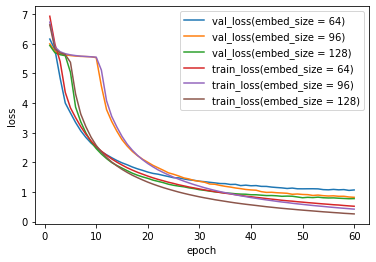

In [77]:
import matplotlib.pyplot as plt
epoch_list = list(range(1, EPOCHS+1))
plt.plot(epoch_list, val_loss_list_64, label = 'val_loss(embed_size = 64)')
plt.plot(epoch_list, val_loss_list_96, label = 'val_loss(embed_size = 96)')
plt.plot(epoch_list, val_loss_list_128, label = 'val_loss(embed_size = 128)')
plt.plot(epoch_list, train_loss_list_64, label = 'train_loss(embed_size = 64)')
plt.plot(epoch_list, train_loss_list_96, label = 'train_loss(embed_size = 96)')
plt.plot(epoch_list, train_loss_list_128, label = 'train_loss(embed_size = 128)')
plt.xlabel('epoch')
plt.ylabel("loss")
plt.legend()

In [78]:
import pickle

val_loss_list_64 = pickle.dumps(val_loss_list_64)
val_loss_list_96 = pickle.dumps(val_loss_list_96)
val_loss_list_128 = pickle.dumps(val_loss_list_128)
train_loss_list_64 = pickle.dumps(train_loss_list_64)
train_loss_list_96 = pickle.dumps(train_loss_list_96)
train_loss_list_128 = pickle.dumps(train_loss_list_128)

In [76]:
train_loss_list_64

[6.9299055714356275,
 5.985303370576156,
 5.405966976232696,
 4.361008881476888,
 3.8389025644252173,
 3.508016726426911,
 3.20567979833536,
 2.9460701743761697,
 2.7206407884756723,
 2.5339837931750115,
 2.3760471443335214,
 2.237714896076604,
 2.1138346906293903,
 2.005207106209638,
 1.9069639177698838,
 1.8153751968291767,
 1.7369716183135384,
 1.6622622839191503,
 1.5978451365964454,
 1.5337559154681992,
 1.4751671678141545,
 1.422109487548209,
 1.3756138439241208,
 1.3262975074742969,
 1.285785338073446,
 1.2404244149986066,
 1.203397383292516,
 1.1648554349677605,
 1.1336008927278352,
 1.0995441026854933,
 1.0674212978858697,
 1.0370844912372137,
 1.0094825745674603,
 0.9803330927041539,
 0.9563315055872265,
 0.9319597745412275,
 0.9056577658966968,
 0.880639794495022,
 0.8553884412374413,
 0.8370998759280172,
 0.8150409015647152,
 0.796758961389985,
 0.7751210905088667,
 0.7562969934129924,
 0.7377143264993241,
 0.7175880606825414,
 0.7003396660612341,
 0.6874979620047829,
 0.66